#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/train_small.npz" /content/
!cp "/content/drive/MyDrive/test_small.npz" /content/
!cp "/content/drive/MyDrive/train_tiny.npz" /content/
!cp "/content/drive/MyDrive/test_tiny.npz" /content/
!cp "/content/drive/MyDrive/train.npz" /content/
!cp "/content/drive/MyDrive/test.npz" /content/

Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [4]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [58]:
from pathlib import Path
import os
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display

CLOUD_CHECKPOINTS = {
    "best": {
        "net_id": "1wy9eU9japgs1PO3TKLGrzgXvGsIOkFM3",  # ID файла best_net.pth в Google Drive
        "rf_id":  "1CnJyednCVfM9Bban7ATRbhTkW1UUS2Ek",  # (опционально) ID файла best_rf.pkl
    }
}

from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import gdown
import tensorflow as tf

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import joblib

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [6]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        # gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 8.
Label code corresponds to TUM class.


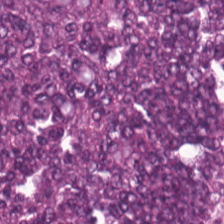

In [7]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [8]:
# ============================================================
# (Опционально) Обёртка над Dataset для использования с PyTorch
# ============================================================

# ВНИМАНИЕ:
# Этот код нужен только тем, кто хочет решать задание с помощью PyTorch.
# Он показывает, как "подключить" наш Dataset к torch.utils.data.DataLoader.

try:
    import torch
    from torch.utils.data import Dataset as TorchDataset, DataLoader
    import torchvision.transforms as T
    from PIL import Image

    class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor
            return img, label

except ImportError:
    HistologyTorchDataset = None
    print("PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.")

##HistologyTorchDataset

Назначение: адаптер между исходным Dataset (с методами image_with_label() и полем labels) и torch.utils.data.DataLoader для обучения ResNet-18.
__init__(base_dataset, indices=None, train=True)

1) base_dataset — объект Dataset('train'), Dataset('test') и т.п.
Ожидается, что у него есть:


*   n_files — количество патчей;
*   labels — массив меток длины n_files;

* метод image_with_label(i) → (img, label), где img — numpy-массив H×W×3 (uint8).

2) indices=None — необязательное подмножество индексов:


*   если None, берём все изображения из base_dataset;
*  если передан массив индексов, датасет работает только на этом подмножестве (удобно для разбиения train/val/test).


3) train=True — флаг, включающий аугментации:


*   если train=True, к пайплайну добавляются случайные горизонтальные/вертикальные флипы, небольшие повороты (RandomRotation), а также ColorJitter (яркость/контраст/насыщенность/оттенок);
* если train=False, используется только детерминированное препроцессирование (без случайных искажений).

4) Внутри собирается пайплайн трансформаций (self.transform):


*   преобразование numpy-массива в PIL.Image (в самом __getitem__);
*  при train=True — аугментации: RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter;

*   ToTensor() — перевод изображения в тензор PyTorch float32 в диапазоне [0, 1];
*   Normalize(mean, std) с параметрами ImageNet ([0.485, 0.456, 0.406] и [0.229, 0.224, 0.225]) — нормализация под вход ResNet-18.





 __len__ — Возвращает количество элементов в датасете, то есть длину массива indices (или base_dataset.n_files, если indices=None).

 __getitem__(idx)


1.   Получает глобальный индекс i = indices[idx].
2.   Вызывает img, label = base_dataset.image_with_label(i).


1.   При необходимости приводит массив к формату H×W×3, создаёт PIL.Image.
2.  Применяет к изображению собранные трансформации (self.transform).


1.  Возвращает пару (img_tensor, label)







In [9]:
class HistologyTorchDataset(TorchDataset):
    """
    Обёртка над твоим Dataset для обучения и тестирования PyTorch-модели.

    base_dataset: объект Dataset('train') или Dataset('test')
    indices: подмножество индексов, которое мы берём (train/val/test split)
    train: флаг, включающий аугментации только для train
    """
    def __init__(self, base_dataset, indices=None, train: bool = True):
        self.base_dataset = base_dataset
        self.train = train

        if indices is None:
            self.indices = np.arange(self.base_dataset.n_files)
        else:
            self.indices = np.array(indices, dtype=int)

        transforms = []

        # --- аугментации ТОЛЬКО на train ---
        if self.train:
            transforms.extend([
                T.RandomHorizontalFlip(p=0.5),
                T.RandomVerticalFlip(p=0.5),
                T.RandomRotation(degrees=10),
                T.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2,
                    hue=0.02
                )
            ])

        transforms.append(T.ToTensor())  # [0,1]

        # Нормализация под ResNet / ImageNet
        imagenet_mean = [0.485, 0.456, 0.406]
        imagenet_std  = [0.229, 0.224, 0.225]
        transforms.append(T.Normalize(mean=imagenet_mean, std=imagenet_std))

        self.transform = T.Compose(transforms)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        img, label = self.base_dataset.image_with_label(idx)  # img: 224x224x3, uint8 (предположительно)

        # На всякий случай приводим к (H, W, 3)
        if img.ndim == 3 and img.shape[0] == 3 and img.shape[-1] != 3:
            img = np.transpose(img, (1, 2, 0))

        img = img.astype(np.uint8)
        img_pil = Image.fromarray(img)

        img_t = self.transform(img_pil)
        return img_t, int(label)


### Пример использвания класса HistologyTorchDataset

In [10]:
if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))


Пример использования PyTorch-обёртки над Dataset
Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
Форма батча изображений: (8, 3, 224, 224)
Форма батча меток: (8,)
Пример меток: [5, 6, 0, 3, 3, 5, 4, 6]
Тип images_batch: <class 'torch.Tensor'>
Тип labels_batch: <class 'torch.Tensor'>


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [11]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

##SimpleCNN

Назначение: реализует сверточную нейросеть на основе предобученного ResNet-18, выдаёт:

-логиты классов для обучения;

-512-мерный эмбеддинг для классического ML-классификатора (RandomForest) в ансамбле.

__init__

- Загружает предобученную архитектуру resnet18 из torchvision.models:
  - при pretrained=True используются веса, обученные на ImageNet;
  - при pretrained=False веса инициализируются случайно.



- Получает размер последнего полносвязного слоя (in_features, обычно 512) и заменяет его на nn.Identity():
   - таким образом, self.backbone возвращает чистый 512-мерный эмбеддинг после глобального pooling.

- Определяет «голову» классификатора:
  - self.dropout — слой Dropout(p=dropout_p) для регуляризации
  - self.fc_out — линейный слой Linear(512, num_classes), который преобразует эмбеддинг в 9 логитов классов.
- При freeze_backbone=True замораживает все параметры self.backbone:
  - обучается только финальный классификатор (fc_out), что позволяет использовать ResNet как фиксированный извлекатель признаков.

__forward_features(x)__

- Прогоняет входной батч картинок x через self.backbone (ResNet-18 без последнего FC).
- Используется для извлечения признаков и последующего обучения RandomForestClassifier в ансамбле.

__forward(x)__

- Вызывает forward_features(x) для получения эмбеддингов.
- Применяет Dropout.

- Прогоняет через self.fc_out, получая логиты формы (batch_size, num_classes).
- Эти логиты используются для расчёта функции потерь CrossEntropyLoss при обучении, построения вероятностей классов через softmax при инференсе и в ансамбле с RandomForest.

In [12]:
class SimpleCNN(nn.Module):
    """
    Вариант 2 (модифицированный): вместо самописной CNN используем ResNet-18
    как feature extractor и небольшой классификатор сверху.

    Интерфейс:
      - forward(x): логиты классов (B, num_classes)
      - forward_features(x): эмбеддинги (B, feat_dim), для RandomForest
    """
    def __init__(self,
                 num_classes: int = 9,
                 pretrained: bool = True,
                 freeze_backbone: bool = False,
                 dropout_p: float = 0.3):
        super().__init__()

        # Загружаем ResNet-18
        if pretrained:
            # Новый API torchvision
            try:
                weights = models.ResNet18_Weights.IMAGENET1K_V1
                backbone = models.resnet18(weights=weights)
            except AttributeError:
                # Старый API
                backbone = models.resnet18(pretrained=True)
        else:
            backbone = models.resnet18(weights=None)

        # Забираем размер последнего слоя и заменяем его на Identity
        in_features = backbone.fc.in_features  # обычно 512
        backbone.fc = nn.Identity()

        self.backbone = backbone
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc_out = nn.Linear(in_features, num_classes)

        # Опционально можно заморозить backbone
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward_features(self, x):
        """
        Возвращает эмбеддинг (B, feat_dim).
        ResNet-18 сам делает глобальный pooling.
        """
        x = self.backbone(x)  # (B, 512)
        return x

    def forward(self, x):
        """
        Логиты классов.
        """
        x = self.forward_features(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x



In [13]:
class NumpySubsetDataset:
    """
    Подмножество исходного Dataset (по индексам),
    но с тем же интерфейсом .images, .labels
    """
    def __init__(self, base_dataset, indices):
        self.images = base_dataset.images[indices]
        self.labels = base_dataset.labels[indices]


In [56]:
import copy
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# ID файлов с весами модели в Google Drive
CNN_WEIGHTS_ID = "1P8VzFOHBmcG0hcP1Ev0iNyTrrTFJSr1U"   # TODO: подставить свой id
SVM_WEIGHTS_ID = "1aJNEjIzjc1FcmkMGKankPVMjnKS0CCPd"   # TODO: подставить свой id

class Model:
    """
    Высокоуровневый класс:
      - делит train на train/val
      - обучает ResNet-18 на 9 классов
      - по эмбеддингам ResNet обучает RandomForest
      - делает ансамблевое предсказание (ResNet + RF)

    Использование:
      d_train = Dataset('train')
      d_test  = Dataset('test')

      model = Model()
      model.fit(d_train)

      model.evaluate_on_dataset(d_test, split_name="TEST")
    """
    def __init__(self,
                 num_classes: int = 9,
                 lr: float = 1e-4,
                 weight_decay: float = 1e-4,
                 epochs: int = 15,
                 batch_size: int = 64,
                 val_split: float = 0.2,
                 patience: int = 5,
                 use_ensemble: bool = True,
                 device: str | None = None):

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)

        self.num_classes = num_classes
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.val_split = val_split
        self.patience = patience
        self.use_ensemble = use_ensemble

        # Наша новая сеть
        self.net = SimpleCNN(
            num_classes=num_classes,
            pretrained=True,
            freeze_backbone=False,
            dropout_p=0.3
        ).to(self.device)

        # Оптимизатор и шедулер
        self.optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, self.net.parameters()),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',   # следим за максимизацией balanced accuracy
            factor=0.5,
            patience=2
        )

        self.criterion = nn.CrossEntropyLoss()

        # классическая ML-модель (RandomForest) по эмбеддингам
        self.ml_model: RandomForestClassifier | None = None

        # сюда будем складывать историю
        self.history = {
            "epoch": [],
            "train_loss": [],
            "val_loss": [],
            "val_bal_acc": []
        }

    # ---------------- вспомогательные методы ---------------- #

    def _train_val_split(self, base_dataset):
        """
        Делим индексы датасета на train/val стратифицированно.
        Требуется, чтобы у base_dataset были поля:
          - n_files
          - labels (np.array длины n_files)
        """
        n_samples = base_dataset.n_files
        labels = np.array(base_dataset.labels, dtype=int)

        indices = np.arange(n_samples)
        train_idx, val_idx = train_test_split(
            indices,
            test_size=self.val_split,
            random_state=42,
            stratify=labels
        )
        return train_idx, val_idx

    def _make_loaders(self, base_dataset):
        """
        Строим PyTorch DataLoader'ы для train и val.
        """
        train_idx, val_idx = self._train_val_split(base_dataset)

        train_ds = HistologyTorchDataset(base_dataset, indices=train_idx, train=True)
        val_ds   = HistologyTorchDataset(base_dataset, indices=val_idx,   train=False)

        train_loader = DataLoader(
            train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        return train_loader, val_loader

    def _train_one_epoch(self, train_loader):
        self.net.train()
        running_loss = 0.0

        for x, y in train_loader:
            x = x.to(self.device)
            y = y.to(self.device)

            self.optimizer.zero_grad()
            logits = self.net(x)
            loss = self.criterion(logits, y)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        return epoch_loss

    def _evaluate_epoch(self, loader):
        """
        Считает loss и balanced accuracy на заданном loader.
        Использует только саму сеть (без RF), потому что RF ещё может быть не обучен.
        """
        self.net.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                y = y.to(self.device)

                logits = self.net(x)
                loss = self.criterion(logits, y)
                running_loss += loss.item() * x.size(0)

                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(y.cpu().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        bal_acc = balanced_accuracy_score(all_labels, all_preds)

        return epoch_loss, bal_acc, all_labels, all_preds

    def _extract_embeddings(self, loader):
        """
        Прогоняет данные через self.net.forward_features
        и возвращает эмбеддинги + метки в виде numpy-массивов.
        Это используется для обучения RandomForest.
        """
        self.net.eval()
        feats_list = []
        labels_list = []

        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                y = y.to(self.device)

                emb = self.net.forward_features(x)   # (B, 512) для ResNet-18
                feats_list.append(emb.cpu().numpy())
                labels_list.append(y.cpu().numpy())

        X = np.concatenate(feats_list, axis=0)
        y = np.concatenate(labels_list, axis=0)
        return X, y

    def fit_rf(self, train_loader):
        """
        Обучаем RandomForestClassifier на эмбеддингах ResNet-18.
        """
        print("Извлекаем эмбеддинги для RandomForest...")
        X_train, y_train = self._extract_embeddings(train_loader)

        rf = RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            n_jobs=-1,
            class_weight="balanced_subsample",
            random_state=42
        )
        rf.fit(X_train, y_train)
        self.ml_model = rf
        print("RandomForest обучен на эмбеддингах. X_train:", X_train.shape)

    def save(self, base_path: str):
        """
        Сохраняем веса сети и RandomForest.
        Получится два файла:
          base_path + "_net.pth"
          base_path + "_rf.pkl"
        """
        torch.save(self.net.state_dict(), base_path + "_net.pth")
        if self.ml_model is not None:
            joblib.dump(self.ml_model, base_path + "_rf.pkl")

    def load(self, base_path: str):
        """
        Загружаем веса нейросети и RandomForest.

        Алгоритм:
        1) Строим локальные пути:
              base_path + "_net.pth"
              base_path + "_rf.pkl"
        2) Если файл сети локально отсутствует:
              - берём ID из CLOUD_CHECKPOINTS[base_path]["net_id"]
              - скачиваем через gdown в net_path
        3) Аналогично для RandomForest (если указан rf_id).
        """

        net_path = base_path + "_net.pth"
        rf_path = base_path + "_rf.pkl"

        # ---------- сеть ----------
        if not os.path.exists(net_path):
            # пробуем найти описание чекпоинта в словаре
            if base_path not in CLOUD_CHECKPOINTS:
                raise FileNotFoundError(
                    f"Локальный файл {net_path} не найден, "
                    f"и в CLOUD_CHECKPOINTS нет записи для '{base_path}'."
                )

            net_id = CLOUD_CHECKPOINTS[base_path].get("net_id", None)
            if net_id is None:
                raise FileNotFoundError(
                    f"Для '{base_path}' в CLOUD_CHECKPOINTS не указан 'net_id', "
                    f"нечего скачивать."
                )

            print(f"[load] Локальный файл {net_path} не найден, "
                  f"скачиваем веса сети из Google Drive (id={net_id})...")
            url = f"https://drive.google.com/uc?id={net_id}"
            gdown.download(url, net_path, quiet=False)
            print(f"[load] Веса сети сохранены в {net_path}")

        # теперь net_path должен существовать
        state_dict = torch.load(net_path, map_location=self.device)
        self.net.load_state_dict(state_dict)
        print(f"[load] Веса сети загружены из {net_path}")

        # ---------- RandomForest ----------
        # RF не обязателен: если нет rf_id и/или файла — просто работаем без ансамбля
        rf_id = None
        if base_path in CLOUD_CHECKPOINTS:
            rf_id = CLOUD_CHECKPOINTS[base_path].get("rf_id", None)

        if not os.path.exists(rf_path) and rf_id is not None:
            try:
                print(f"[load] Локальный файл {rf_path} не найден, "
                      f"скачиваем RandomForest из Google Drive (id={rf_id})...")
                url = f"https://drive.google.com/uc?id={rf_id}"
                gdown.download(url, rf_path, quiet=False)
                print(f"[load] RandomForest сохранён в {rf_path}")
            except Exception as e:
                print(f"[load] Не удалось скачать RandomForest из облака: {e}")

        if os.path.exists(rf_path):
            self.ml_model = joblib.load(rf_path)
            print(f"[load] RandomForest загружен из {rf_path}")
        else:
            self.ml_model = None
            print("[load] RandomForest не найден, модель будет работать без ансамбля.")

    def _predict_proba_batch(self, x):
        """
        Возвращает ансамблевые вероятности классов для батча x.
        Если ml_model ещё не обучен, возвращает только softmax сети.
        """
        self.net.eval()
        with torch.no_grad():
            x = x.to(self.device)

            logits = self.net(x)
            probs_cnn = torch.softmax(logits, dim=1)  # (B, num_classes)

            if self.ml_model is None or not self.use_ensemble:
                return probs_cnn

            # Эмбеддинги для RF
            emb = self.net.forward_features(x)        # (B, feat_dim)
            emb_np = emb.cpu().numpy()
            probs_rf_np = self.ml_model.predict_proba(emb_np)  # (B, num_classes)
            probs_rf = torch.from_numpy(probs_rf_np).to(self.device)

            # Ансамбль: простое усреднение
            probs = 0.5 * probs_cnn + 0.5 * probs_rf
            return probs

    # ---------------- основной интерфейс ---------------- #

    def fit(self, base_dataset):
        """
        Полный цикл:
          1) train/val split
          2) обучение ResNet-18
          3) обучение RandomForest на эмбеддингах train
        """
        train_loader, val_loader = self._make_loaders(base_dataset)

        best_val_bal_acc = -1.0
        best_state_dict = None
        no_improve = 0

        for epoch in range(1, self.epochs + 1):
            train_loss = self._train_one_epoch(train_loader)
            val_loss, val_bal_acc, y_val, y_val_pred = self._evaluate_epoch(val_loader)

            self.history["epoch"].append(epoch)
            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["val_bal_acc"].append(val_bal_acc)

            print(f"Epoch {epoch:02d}: "
                  f"train_loss={train_loss:.4f}, "
                  f"val_loss={val_loss:.4f}, "
                  f"val_bal_acc={val_bal_acc:.4f}")

            # шедулер по валидационному balanced accuracy
            self.scheduler.step(val_bal_acc)

            # ранняя остановка
            if val_bal_acc > best_val_bal_acc:
                best_val_bal_acc = val_bal_acc
                best_state_dict = self.net.state_dict()
                no_improve = 0
                print("  -> новая лучшая модель по balanced accuracy")
            else:
                no_improve += 1
                if no_improve >= self.patience:
                    print(f"Ранняя остановка: {self.patience} эпох без улучшений")
                    break

        # восстановим лучшие веса
        if best_state_dict is not None:
            self.net.load_state_dict(best_state_dict)

        # обучаем RandomForest на train-эмбеддингах (после обучения сети)
        if self.use_ensemble:
            self.fit_rf(train_loader)

    def evaluate_on_loader(self, loader, split_name="DATA"):
        """
        Оценка на любом DataLoader с учётом ансамбля (ResNet + RF).
        """
        self.net.eval()
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for x, y in loader:
                probs = self._predict_proba_batch(x)   # (B, num_classes)
                all_probs.append(probs.cpu().numpy())
                all_labels.append(y.numpy())

        probs = np.concatenate(all_probs, axis=0)
        y_true = np.concatenate(all_labels, axis=0)
        y_pred = probs.argmax(axis=1)

        bal_acc = balanced_accuracy_score(y_true, y_pred)
        print(f"{split_name}: balanced accuracy = {bal_acc:.4f}")
        print(classification_report(y_true, y_pred, target_names=TISSUE_CLASSES))

        cm = confusion_matrix(y_true, y_pred)
        return bal_acc, y_true, y_pred, cm

    def evaluate_on_dataset(self, base_dataset, split_name="DATA", train_flag=False):
        """
        Строит DataLoader по всему датасету (без аугментаций) и считает метрики.
        """
        indices = np.arange(base_dataset.n_files)
        ds = HistologyTorchDataset(base_dataset, indices=indices, train=train_flag)
        loader = DataLoader(ds, batch_size=self.batch_size, shuffle=False,
                            num_workers=2, pin_memory=True)
        return self.evaluate_on_loader(loader, split_name=split_name)

    def test_on_dataset(self, base_dataset, limit: float = 1.0, train_flag: bool = False):
        """
        Совместимость с финальной проверочной ячейкой из задания.

        Возвращает только предсказанные метки (np.array), как это делал
        старый test_on_dataset.

        limit: доля датасета (0..1), по умолчанию 1.0 = весь датасет.
        """
        n_total = base_dataset.n_files
        n_use = int(n_total * limit)
        indices = np.arange(n_use)

        ds = HistologyTorchDataset(base_dataset, indices=indices, train=train_flag)
        loader = DataLoader(
            ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        self.net.eval()
        all_probs = []
        with torch.no_grad():
            for x, _ in loader:
                # сюда уже зашит ансамбль ResNet + RF
                probs = self._predict_proba_batch(x)
                all_probs.append(probs.cpu().numpy())

        probs = np.concatenate(all_probs, axis=0)
        y_pred = probs.argmax(axis=1)
        return y_pred


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [28]:
d_train = Dataset('train')
d_test = Dataset('test')

Loading dataset train from npz.
Done. Dataset train consists of 18000 images.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [33]:
model = Model(
    num_classes=len(TISSUE_CLASSES),
    lr=1e-4,
    weight_decay=1e-4,
    epochs=15,
    batch_size=64,
    val_split=0.2,
    patience=5,
    use_ensemble=True
)

model.fit(d_train)

print("\n=== Оценка на train (без аугментаций) ===")
model.evaluate_on_dataset(d_train, split_name="TRAIN_FULL", train_flag=False)

print("\n=== Оценка на test ===")
model.evaluate_on_dataset(d_test, split_name="TEST", train_flag=False)

Epoch 01: train_loss=0.2832, val_loss=0.1422, val_bal_acc=0.9528
  -> новая лучшая модель по balanced accuracy
Epoch 02: train_loss=0.1040, val_loss=0.0884, val_bal_acc=0.9733
  -> новая лучшая модель по balanced accuracy
Epoch 03: train_loss=0.0852, val_loss=0.0697, val_bal_acc=0.9772
  -> новая лучшая модель по balanced accuracy
Epoch 04: train_loss=0.0640, val_loss=0.0585, val_bal_acc=0.9828
  -> новая лучшая модель по balanced accuracy
Epoch 05: train_loss=0.0640, val_loss=0.0585, val_bal_acc=0.9836
  -> новая лучшая модель по balanced accuracy
Epoch 06: train_loss=0.0566, val_loss=0.0414, val_bal_acc=0.9858
  -> новая лучшая модель по balanced accuracy
Epoch 07: train_loss=0.0383, val_loss=0.0832, val_bal_acc=0.9767
Epoch 08: train_loss=0.0387, val_loss=0.0547, val_bal_acc=0.9814
Epoch 09: train_loss=0.0362, val_loss=0.0425, val_bal_acc=0.9858
Epoch 10: train_loss=0.0232, val_loss=0.0412, val_bal_acc=0.9869
  -> новая лучшая модель по balanced accuracy
Epoch 11: train_loss=0.0145,

(np.float64(0.9897777777777779),
 array([0, 0, 0, ..., 8, 8, 8]),
 array([0, 0, 0, ..., 8, 8, 8]),
 array([[499,   0,   0,   0,   0,   0,   0,   1,   0],
        [  0, 500,   0,   0,   0,   0,   0,   0,   0],
        [  1,   0, 492,   0,   0,   0,   0,   7,   0],
        [  0,   0,   0, 499,   0,   0,   0,   1,   0],
        [  0,   0,   0,   0, 496,   0,   0,   4,   0],
        [  0,   0,   1,   0,   0, 490,   1,   8,   0],
        [  0,   0,   0,   2,   3,   0, 492,   2,   1],
        [  0,   0,   4,   0,   0,   6,   0, 490,   0],
        [  0,   0,   2,   1,   0,   0,   1,   0, 496]]))

In [49]:
model.fit_rf(train_loader)   # train_loader из Model или внешний
model.save('best')

Извлекаем эмбеддинги для RandomForest...
RandomForest обучен на эмбеддингах. X_train: (900, 512)


Пример тестирования модели на части набора данных:

In [50]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

metrics for 10% of test:
	 accuracy 0.9889:
	 balanced accuracy 0.9889:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [51]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

metrics for test:
	 accuracy 0.9596:
	 balanced accuracy 0.9596:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [59]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

[load] Веса сети загружены из best_net.pth
[load] RandomForest загружен из best_rf.pkl
Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
metrics for test-tiny:
	 accuracy 0.9667:
	 balanced accuracy 0.9667:


Отмонтировать Google Drive.

In [54]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

# Матрица ошибок + визуализация в новом API
cm = metrics.confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### PyTorch

In [ ]:
# ============================================================
# Дополнительно: мини-демо PyTorch
# ============================================================
# Ранний выход, если PyTorch/обёртка недоступны
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
except ImportError:
    print("PyTorch не установлен — демо пропущено.")
    import sys
    raise SystemExit

if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("HistologyTorchDataset недоступна — демо пропущено.")
    import sys
    raise SystemExit


# --- Данные: tiny-наборы, чтобы выполнялось быстро ---
base_train = Dataset('train_tiny')
base_test  = Dataset('test_tiny')

train_ds = HistologyTorchDataset(base_train)           # ToTensor по умолчанию
test_ds  = HistologyTorchDataset(base_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# --- Мини-модель: двухслойный CNN + один FC (демонстрация, не решение) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=len(TISSUE_CLASSES)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # 224->112->56
        self.fc    = nn.Linear(16 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 3, 224, 224] -> [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 112, 112] -> [B, 16, 56, 56]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TinyCNN(num_classes=len(TISSUE_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Один учебный шаг "обучения" на одном батче ---
model.train()
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device, dtype=torch.long)

optimizer.zero_grad()
logits = model(xb)
loss = criterion(logits, yb)
float_loss = float(loss.detach().cpu())
loss.backward()
optimizer.step()

print(f"Loss на одном батче train_tiny: {float_loss:.4f}")

# --- Быстрая проверка на одном батче теста (для формы вывода/метрик) ---
model.eval()
with torch.no_grad():
    xt, yt = next(iter(test_loader))
    xt = xt.to(device)
    logits_t = model(xt).cpu()
    y_pred = logits_t.argmax(dim=1).numpy()
    y_true = yt.numpy()

print("Размерности:", {"y_true": y_true.shape, "y_pred": y_pred.shape})
Metrics.print_all(y_true, y_pred, "_")  # balanced accuracy/accuracy на одном батче для демонстрации

# для полноценного решения требуется собственный тренировочный цикл по эпохам,
# аугментации/нормализация, сохранение/загрузка весов, и тестирование на всём наборе.

### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"